<a href="https://colab.research.google.com/github/anoodleReza/Google-Colab-Projects/blob/main/computer_vision_fire_detection_group_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Dependencies

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

import os
import shutil
import random
import glob
import cv2

import numpy as np
import opendatasets as od
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

# Data Acquisition

In [ ]:
# requires kaggle.json to be imported in files
od.download('https://www.kaggle.com/datasets/phylake1337/fire-dataset?select=fire_dataset')
od.download('https://www.kaggle.com/datasets/arnaud58/landscape-pictures')

100%|██████████| 387M/387M [00:18<00:00, 22.1MB/s]


100%|██████████| 620M/620M [00:29<00:00, 21.7MB/s]


In [ ]:
fireImg = glob.glob('/content/fire-dataset/fire_dataset/fire_images/*.png')
nonFireImg = glob.glob('/content/fire-dataset/fire_dataset/non_fire_images/*.png')
nonFireImg2 = glob.glob('/content/landscape-pictures/*.jpg')

In [ ]:
# obtaining the image quantities for each class
print('Images with fire : {}'.format(len(fireImg)))
print('Images without fire : {}'.format(len(nonFireImg)))

Images with fire : 755
Images without fire : 244


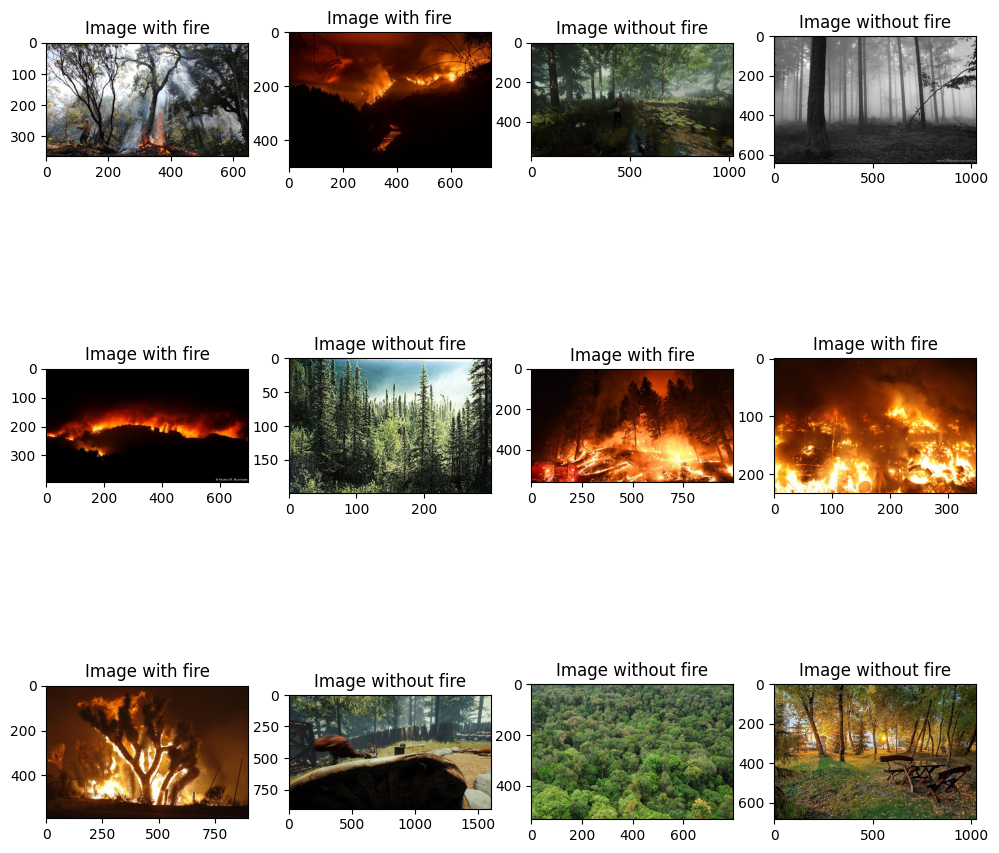

In [ ]:
# Image Visualization
randomImage = random.sample(fireImg,6) + random.sample(nonFireImg,6)
random.shuffle(randomImage)

plt.figure(figsize = (12,12))

for i in range(len(randomImage)):
    plt.subplot(3,4,i+1)
    if "non_fire" in randomImage[i]:
        img = cv2.imread(randomImage[i])
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        plt.imshow(img,cmap = 'gray')
        plt.title('Image without fire')
    else:
        img = cv2.imread(randomImage[i])
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        plt.imshow(img,cmap = 'gray')
        plt.title("Image with fire")

plt.show()

# Data Preprocessing


After looking at the primary dataset, we can see that there are 511 more images with fire, so we will add 511 landscape iamges into the non-fire data

In [ ]:
# Adding a target label as a new column
fire = []
for x in fireImg:
  fire.append([x,1])

nonFire = []
for x in nonFireImg:
  nonFire.append([x,0])

# Shuffle the secondary database
random.seed(42)
random.shuffle(nonFireImg2)
toadd = nonFireImg2[:511]

for x in toadd:
  nonFire.append([x,0])

# Combine the data
completeSet = fire + nonFire

# shuffle dataset based on a seed for consistency
random.shuffle(completeSet)

In [ ]:
print('Total Images : {}'.format(len(completeSet)))

Total Images : 1510


In [ ]:
# setup dataframe
df = pd.DataFrame(completeSet,columns = ['files','target'])
df.head(8)

,files,target
0,/content/landscape-pictures/00000424_(3).jpg,0
1,/content/fire-dataset/fire_dataset/non_fire_im...,0
2,/content/fire-dataset/fire_dataset/fire_images...,1
3,/content/fire-dataset/fire_dataset/fire_images...,1
4,/content/landscape-pictures/00000421.jpg,0
5,/content/fire-dataset/fire_dataset/fire_images...,1
6,/content/fire-dataset/fire_dataset/fire_images...,1
7,/content/fire-dataset/fire_dataset/non_fire_im...,0


In [ ]:
# Preprocessing steps to be done to each image
def preprocess(filepath):
    img = cv2.imread(filepath)

    if img is None:
        print(f"Error reading image: {filepath}")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, (160, 160))
    img = img / 255
    return img

# Function to preprocess all valid images
def formatData(dataframe):
    a = []
    b = []

    for files, target in dataframe.values:
        preprocessed_img = preprocess(files)
        if preprocessed_img is not None:
            a.append(preprocessed_img)
            b.append(target)

    return np.array(a, dtype=object), np.array(b)

In [ ]:
X, y = formatData(df)

Error reading image: /content/fire-dataset/fire_dataset/non_fire_images/non_fire.189.png


In [ ]:
X.shape, y.shape

((1509, 160, 160, 3), (1509,))

# Dataset Splitting

In [ ]:
# Split the data into training set and testing set
X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.7, stratify = y, random_state=42)
# Split the data into training set and testing set and validation set
X_validation, X_test, y_validation, y_test = train_test_split(X_other, y_other, train_size = 0.5, stratify = y_other, random_state=42)

In [ ]:
print("Train Shape: ",X_train.shape)
print("Test Shape: ",X_test.shape)
print("Validation Shape: ",X_validation.shape)

Train Shape:  (1056, 160, 160, 3)
Test Shape:  (227, 160, 160, 3)
Validation Shape:  (226, 160, 160, 3)


# CNN

In [ ]:
# building the CNN model
model = Sequential()

model.add(Conv2D(128,(2,2),input_shape = (160,160,3)))
model.add(Activation("relu"))

model.add(Conv2D(64,(2,2)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(32,(2,2)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1,activation= "sigmoid"))

# Training

In [ ]:
# converting array
X_train = np.array(X_train).astype('float32')
y_train = np.array(y_train)
X_test = np.array(X_test).astype('float32')
y_test = np.array(y_test)
X_validation = np.array(X_validation).astype('float32')
y_validation = np.array(y_validation)

In [ ]:
# Training the model
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True)]

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_validation,y_validation), epochs = 30, batch_size = 8, callbacks = callbacks)

Epoch 1/30
132/132 [==============================] - 6s 32ms/step - loss: 0.1401 - accuracy: 0.9621 - val_loss: 0.3359 - val_accuracy: 0.8850
Epoch 2/30
132/132 [==============================] - 4s 29ms/step - loss: 0.0603 - accuracy: 0.9763 - val_loss: 0.3971 - val_accuracy: 0.8938
Epoch 3/30
132/132 [==============================] - 4s 29ms/step - loss: 0.0851 - accuracy: 0.9735 - val_loss: 0.4663 - val_accuracy: 0.8673
Epoch 4/30
132/132 [==============================] - 4s 29ms/step - loss: 0.0516 - accuracy: 0.9792 - val_loss: 0.7327 - val_accuracy: 0.8451
Epoch 5/30
132/132 [==============================] - 4s 29ms/step - loss: 0.0599 - accuracy: 0.9763 - val_loss: 0.8138 - val_accuracy: 0.8805
Epoch 6/30
132/132 [==============================] - 4s 28ms/step - loss: 0.0750 - accuracy: 0.9801 - val_loss: 0.9554 - val_accuracy: 0.8894
Epoch 7/30
132/132 [==============================] - 4s 29ms/step - loss: 0.0885 - accuracy: 0.9744 - val_loss: 0.5816 - val_accuracy: 0.8717

In [ ]:
# Saving the model
model.save("group4 v2.h5")

In [ ]:
file_path = '/content/group4 v2.h5'
destination_folder_path = '/content/drive/MyDrive/UGM S1/SEM 4/CV group 4/'

shutil.copy(file_path, destination_folder_path)

'/content/drive/MyDrive/UGM S1/SEM 4/CV group 4/group4 v2.h5'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load model from downloaded files if needed
loaded_model = load_model('/content/group4.h5')

# Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Get the predicted classes for the test set
y_pred = loaded_model.predict(X_test)
y_pred = (y_pred > 0.5)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix and classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

8/8 [==============================] - 1s 37ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       113
           1       0.96      0.89      0.93       114

    accuracy                           0.93       227
   macro avg       0.93      0.93      0.93       227
weighted avg       0.93      0.93      0.93       227



# Predictions & Detect funcntion

Link to the google drive with the model:
https://drive.google.com/drive/folders/1i1zL3b6sHQINxpFCrVK6NVfJCMLpy8bE?usp=sharing

In [ ]:
# Download the model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gdown
# Change the id if the model is changed
!gdown --id 1-7438gT62NBverjPYfQQ_hDmTDLSBuiE --output /content/drive/MyDrive/group4.h5

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-7438gT62NBverjPYfQQ_hDmTDLSBuiE
To: /content/drive/MyDrive/group4.h5
100% 75.3M/75.3M [00:01<00:00, 54.8MB/s]


In [ ]:
from keras.models import load_model

# Loading the already trained model
loaded_model = load_model('/content/drive/MyDrive/group4.h5')

# **Detect Function**

Since our model outputs a binary prediction of whether the image contains fire or not (0 being no fire and 1 being fire), then we need to utilize a sliding windows approach in order to generate a binary image. As such, there will be some discreptancies between the results of shown in the binary image and the overall classification of the image.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def detect(img_path):
    # read the image
    img = cv2.imread(img_path)

    if img is None:
        print(f"Error reading image: {img_path}")
        return None

    if(img.shape[1] > 1600):
      img = cv2.resize(img, None, fx=0.5, fy=0.5)

    # preprocessing the images given
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, (160, 160))
    img = img / 255
    img = np.expand_dims(img, axis=0)

    # evaluating the model using the data given
    predicition = 'There is no Fire'
    y_pred = loaded_model.predict(img)
    print(y_pred)
    if (y_pred > 0.5):
      predicition = 'There is Fire'

    image = plt.imread(img_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Load and preprocess the image
    image = cv2.imread(img_path)

    # Get the image dimensions
    image_height, image_width, _ = image.shape

    # Define sliding window size and stride
    window_size = (int(image_height / 20), int(image_height / 20))
    stride = int(image_height / 40)

    if((image_height / 20) < 80):
        window_size = (80,80)
        stride = 40

    # Initialize an empty binary mask
    binary_mask = np.zeros((image_height, image_width), dtype=np.uint8)

    # Iterate over the image using sliding window
    for y in range(0, image_height - window_size[0] + 1, stride):
        for x in range(0, image_width - window_size[1] + 1, stride):
            window = image[y:y+window_size[0], x:x+window_size[1], :]

            resized_window = cv2.resize(window, (160, 160))

            # Preprocess the resized window
            resized_window = cv2.cvtColor(resized_window, cv2.COLOR_RGB2BGR)
            resized_window = resized_window / 255
            resized_window = np.expand_dims(resized_window, axis=0)

            prediction = loaded_model.predict(resized_window, verbose=0)

            if prediction > 0.8:
                binary_mask[y:y+window_size[0], x:x+window_size[1]] = 255

    # Display the binary mask
    plt.imshow(binary_mask, cmap='gray')
    plt.axis('off')
    plt.show()

    return predicition

Use detect('path/to/image.jpg') for detection or print(detect('/path/to/image.jpg')) to also print the class of the image. Depending on the resolution of the image, the detect process might take a while since we are using sliding windows

1/1 [==============================] - 0s 27ms/step
[[3.5206817e-06]]


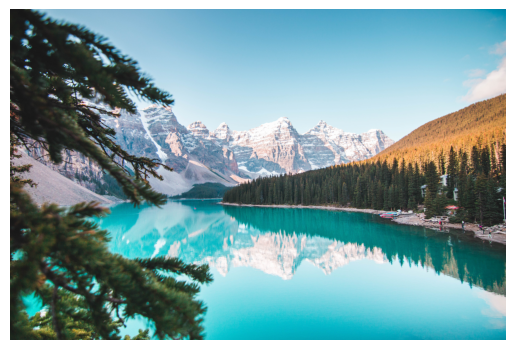

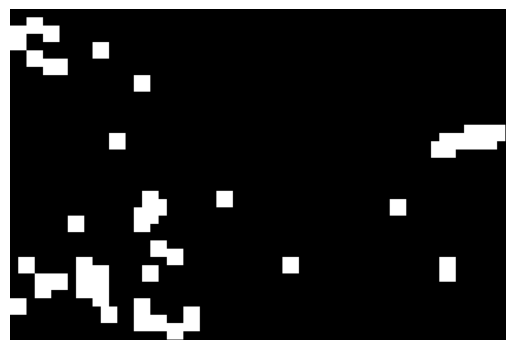

There is no Fire


In [ ]:
print(detect('/content/lands.jpg'))

1/1 [==============================] - 0s 24ms/step
[[0.9768679]]


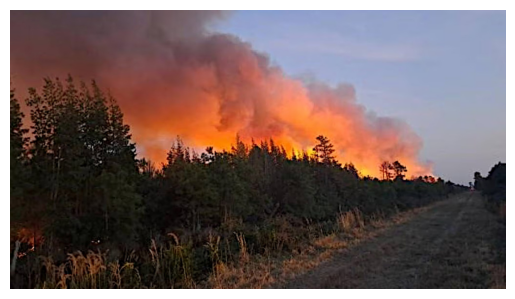

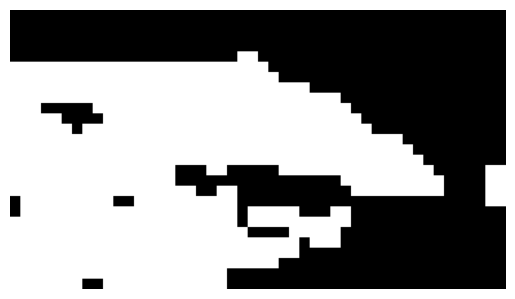

There is Fire


In [ ]:
print(detect('/content/wildfire2.jpg'))